# Mesoscopic V2

In [1]:
### command to show execution time

%load_ext autotime


time: 0 ns


## Text processing

### Gutenberg project

In [76]:
### retrieve gutenberg book 

from gutenberg.query import get_metadata
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers

def retrieve_text(index):
    try:
        text = strip_headers(load_etext(index)).strip()
    except:
        text = ""
    return text

def retrieve_author(index):
    return list(get_metadata('author', index))[0]

def retrieve_title(index):
    return list(get_metadata('title', index))

def retrieve_languages(index):
    return list(get_metadata('language', index))

def retrieve_subjects(index):
    return list(get_metadata('subject', index))

time: 47 ms


## Retrieving all networks

In [77]:
### code to retrieve all networks from 'pca 300 networks' folder and store it in an array 

import os
import pickle

def getNetworks(window):

    networks = []
    path = './pca 300 networks new right/'
    directory = os.fsencode(path)

    for file in os.listdir(directory):
        filename = path + os.fsdecode(file)
        if filename.endswith(str(window)+".p"):
            f = open(filename, 'rb')
            G = pickle.load(f)
            f.close()

            # getting gutenberg_id and saving on graph
            start = len(path) + len('network_')
            end = len('_w'+ str(window) + '.p')
            gutenberg_id = filename[start:-end]
            
            G['gutenberg_id'] = gutenberg_id
            networks.append(G)
            
    return networks

time: 15 ms


In [4]:
### filter edges of the networks in the array based on fixed avg degree

def filterNetworkEdges(networks, avg_degree):
    filteredNetworks = []
    for G in networks:
        # filtering edges based on the avg degree that we want
        weights = sorted(G.es['weight'], reverse=True)
        newECount = avg_degree * G.vcount() // 2
        minWeight = weights[min(newECount, len(weights)-1)]
        G.es.select(weight_lt=minWeight).delete()
        filteredNetworks.append(G)
    return filteredNetworks

time: 0 ns


## Joining with side project: extracting communities from subjects network

In [9]:
from collections import Counter

def format_subject(subject):
    return ''.join(c for c in subject if c.lower() in 'abcdefghijklmnopqrstuvwxyz1234567890 -')

def get_book_community(book_id):
    subjects = [format_subject(subj) for subj in retrieve_subjects(book_id)]
    targets = [dic_subj_comm[subj] for subj in subjects]

    return 'fiction' if Counter(targets).most_common(1)[0][0] <= 1 else 'others'
#     return 'fiction' if Counter(targets).most_common(1)[0][0] == 0 else 'juvenile fiction' if Counter(targets).most_common(1)[0][0] == 1 else 'others'

In [10]:
import xnetwork as xn
from igraph import *
import matplotlib.pyplot as plt

G = xn.xnet2igraph('projection_onto_subjects_comm.xnet')

dic_subj_comm = {}

N_COMM = 2
for v in G.vs:
    dic_subj_comm[v['name']] = int(v['Community']) if int(v['Community']) < N_COMM else N_COMM

dic_comm_subj = {}
for k, v in dic_subj_comm.items():
    if v in dic_comm_subj:
        dic_comm_subj[v].append(k)
    else:
        dic_comm_subj[v] = [k]


In [7]:
dic_subj_comm

{'United States -- History -- Revolution 1775-1783 -- Sources': 2,
 'JK': 2,
 'United States Declaration of Independence': 2,
 'E201': 2,
 'Civil rights -- United States -- Sources': 2,
 'KF': 2,
 'United States Constitution 1st-10th Amendments': 2,
 'Presidents -- United States -- Inaugural addresses': 2,
 'E838': 2,
 'United States -- Foreign relations -- 1961-1963': 2,
 'E456': 2,
 'Soldiers National Cemetery Gettysburg Pa': 2,
 'Lincoln Abraham 1809-1865 Gettysburg address': 2,
 'Consecration of cemeteries -- Pennsylvania -- Gettysburg': 2,
 'United States Constitution': 2,
 'United States -- Politics and government -- 1783-1789 -- Sources': 2,
 'Virginia -- Politics and government -- 1775-1783 -- Sources': 2,
 'Speeches addresses etc American': 2,
 'United States -- Politics and government -- 1775-1783 -- Sources': 2,
 'Pilgrims New Plymouth Colony': 2,
 'Massachusetts -- History -- New Plymouth 1620-1691 -- Sources': 2,
 'F001': 2,
 'Mayflower Compact 1620': 2,
 'United States --

time: 31 ms


### Setting the chosen configs

In [80]:
### loading networks

window = 4
avg_degree = 3

networks = getNetworks(window)
filtered = filterNetworkEdges(networks, avg_degree)

time: 10.2 s


In [9]:
import xnetwork as xn

maxi = 0
id = 0

for G in filtered:
    if G.vcount() > maxi:
        maxi = G.vcount()
        id = G['gutenberg_id']
        
print(maxi, id)

1950 34395
time: 0 ns


### Checking if accessibility alone is discriminating

In [59]:
import numpy as np

def get_accessibility_and_symmetry(id, level=2, type='Backbone'):
    path = './pca 300 networks new right/network_' + id + '.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h='+str(level)]), np.mean(df[type+' Accessibility h='+str(level)])


def get_accessibility_mean_and_std(id, level=2):
    path = './pca 300 networks new right/network_' + id + '.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h='+str(level)]), np.std(df['Accessed Nodes h='+str(level)])

time: 0 ns


TypeError: unsupported operand type(s) for +: 'type' and 'str'

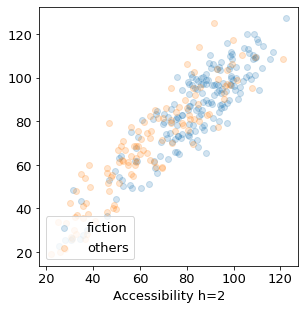

time: 4.62 s


In [60]:
### media acessibilidade vs. media simetria

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 13})

accessibilities = []
symmetries = []
targets = []

for G in networks:
    id = G['gutenberg_id']
    acc, sim = get_accessibility_mean_and_std(id)
    accessibilities.append(acc)
    symmetries.append(sim)
    targets.append(get_book_community(id))
    

df = pd.DataFrame()
df['accessibilities'] = accessibilities
df['symmetries'] = symmetries
df['targets'] = targets

fig = plt.figure(figsize=(6, 6))
fig.add_axes([0.1, 0.1, 0.6, 0.6])

for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['accessibilities'], df_filt['symmetries'], alpha=0.2, label=label)
    
plt.legend(loc="lower left")
# plt.suptitle("Discriminating genre using accessibility and " + type + " symmetry h=" + str(level))
plt.xlabel("Accessibility h="+str(level))
plt.ylabel(type + " symmetry h="+str(level))

# first barplot
fig.add_axes([0.1, 0.7, 0.6, 0.2])
bins=np.linspace(min(accessibilities), max(accessibilities) + 1, 30)

hor_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['accessibilities'], bins=bins, density=True)
plt.plot(hor_hist_f[1][:-1], hor_hist_f[0])

hor_hist_o = np.histogram(df.loc[df['targets'] == 'others']['accessibilities'], bins=bins, density=True)
plt.plot(hor_hist_o[1][:-1], hor_hist_o[0])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)), fontsize=12)
plt.axis('on')
plt.xticks([])

# # second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
bins=np.linspace(min(symmetries), max(symmetries) + 1, 30)

vert_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['symmetries'], bins=bins, density=True)
plt.plot(vert_hist_f[0], vert_hist_f[1][:-1])

vert_hist_o = np.histogram(df.loc[df['targets'] == 'others']['symmetries'], bins=bins, density=True)
plt.plot(vert_hist_o[0], vert_hist_o[1][:-1])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)), fontsize=12)
plt.axis('on')
plt.yticks([])

# plt.tight_layout()
# plt.savefig('./images/scores/acc_sim_genre_'+str(level)+'_'+type+'.pdf')
plt.show()

In [61]:
df = pd.DataFrame()
df['means'] = accessibilities
df['stds'] = symmetries
df['targets'] = targets

### gi's code to plot same chart as above ###

## first, rmse calc ##
# ref: https://stackoverflow.com/questions/60512271/how-can-i-extract-the-bins-from-seaborns-kde-distplot-object
from scipy import stats

def iqr(a):
    """Calculate the IQR for an array of numbers."""
    # ref: https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/distributions.py#L24
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    
    return q3 - q1

def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    # ref: https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/utils.py#L359
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))
    
    
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    y_actual = y_actual[0]
    y_predicted = y_predicted[0]
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 4)
    
def rmse2(a, b, min_, max_):
    bins_qtt = min([_freedman_diaconis_bins(a), _freedman_diaconis_bins(b), 50])
    
    bins = np.linspace(min_, max_ + 0.01, bins_qtt)

    return rmse(np.histogram(a, bins=bins, density=True), np.histogram(b, bins=bins, density=True))


time: 0 ns


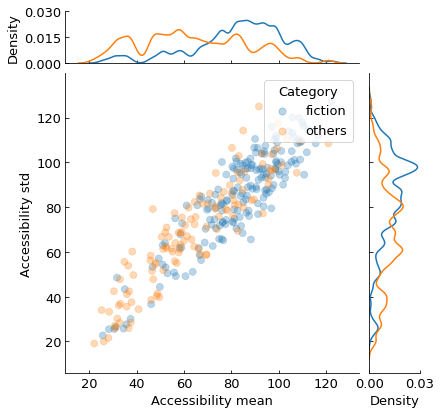

time: 1.98 s


In [62]:
import seaborn as sns

grid = sns.JointGrid(x=df.sort_values('targets')['means'], y=df.sort_values('targets')['stds'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, 
                    alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Accessibility std')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[0], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[0], visible=False)

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1, title="Category")
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='fiction', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(x=df.loc[df['targets']=='others', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=df.loc[df['targets']=='fiction', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=df.loc[df['targets']=='others', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)

g.ax_marg_x.set_yticks([0.000, 0.015, 0.030])
g.ax_marg_y.set_xticks([0.00, 0.03])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

# g.ax_marg_x.text(121, 0.01, "RMSE:\n" + str(rmse2(df.loc[df['targets']=='fiction', 'means'], 
#                                            df.loc[df['targets']=='others', 'means'], 
#                                            min(df['means'].values), max(df['means'].values))))



# g.ax_marg_y.text(0.01, 103.5, "RMSE:\n" + str(rmse2(df.loc[df['targets']=='fiction', 'stds'], 
#                                            df.loc[df['targets']=='others', 'stds'], 
#                                            min(df['stds'].values), max(df['stds'].values))))

# print(rmse2(df.loc[df['targets']=='fiction', 'means'], df.loc[df['targets']=='others', 'means'], 
#             min(df['means'].values), max(df['means'].values)))
# print(rmse2(df.loc[df['targets']=='fiction', 'stds'], df.loc[df['targets']=='others', 'stds'], 
#             min(df['stds'].values), max(df['stds'].values)))



g.savefig('access_mean_std.pdf', bbox_inches='tight')
# g.show()

In [18]:
import numpy as np

def get_accessibility_mean_and_std(id, level):
    path = './pca 300 networks new right/network_' + id + '.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h='+str(level)]), np.std(df['Accessed Nodes h='+str(level)])


def get_symmetry_mean_and_std(id, level):
    path = './pca 300 networks new right/network_' + id + '.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Backbone Accessibility h='+str(level)]), np.std(df['Backbone Accessibility h='+str(level)])


time: 0 ns


In [14]:
import math 


# Root mean square error (rmse)
def calc_separation_score(x, y):
    x = x[0]
    y = y[0]
    
    score = 0
    for i in range(29):
        score += (x[i] - y[i])**2

    score /= 29
    score = math.sqrt(score)
    return round(score, 4)

from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    y_actual = y_actual[0]
    y_predicted = y_predicted[0]
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 4)

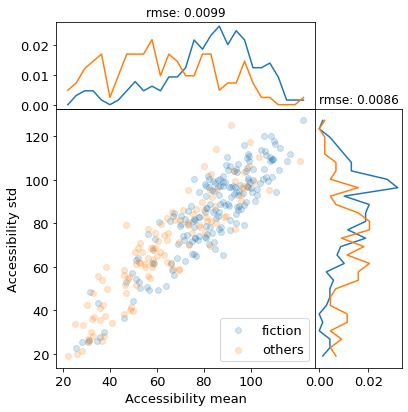

time: 2.92 s


In [49]:
### media acessibilidade vs. std acessibilidade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})

means = []
stds = []
targets = []
level = 2

for G in networks:
    id = G['gutenberg_id']
    mean, std = get_accessibility_mean_and_std(id, level)
    means.append(mean)
    stds.append(std)
    targets.append(get_book_community(id))


df = pd.DataFrame()
df['means'] = means
df['stds'] = stds
df['targets'] = targets

fig = plt.figure(figsize=(6, 6))
fig.add_axes([0.1, 0.1, 0.6, 0.6])

for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['means'], df_filt['stds'], alpha=0.2, label=label)
    
plt.legend(loc="lower right")
# plt.suptitle("Discriminating genre using accessibility h=" + str(level))

plt.xlabel("Accessibility mean")
plt.ylabel("Accessibility std")
plt.xticks([20, 40, 60, 80, 100])

# first barplot
fig.add_axes([0.1, 0.7, 0.6, 0.2])
bins=np.linspace(min(means), max(means) + 1, 30)

hor_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['means'], bins=bins, density=True)
plt.plot(hor_hist_f[1][:-1], hor_hist_f[0])

hor_hist_o = np.histogram(df.loc[df['targets'] == 'others']['means'], bins=bins, density=True)
plt.plot(hor_hist_o[1][:-1], hor_hist_o[0])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)), fontsize=12)
plt.axis('on')
plt.xticks([])

# # second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
bins=np.linspace(min(stds), max(stds) + 1, 30)

vert_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['stds'], bins=bins, density=True)
plt.plot(vert_hist_f[0], vert_hist_f[1][:-1])

vert_hist_o = np.histogram(df.loc[df['targets'] == 'others']['stds'], bins=bins, density=True)
plt.plot(vert_hist_o[0], vert_hist_o[1][:-1])

plt.title("rmse: " + str(rmse(vert_hist_f, vert_hist_o)), fontsize=12)
plt.axis('on')
plt.yticks([])

# plt.tight_layout()
plt.savefig('./images/scores/only_acc_genre_h'+str(level)+'.pdf')
plt.show()

## Discriminating real from meaningless

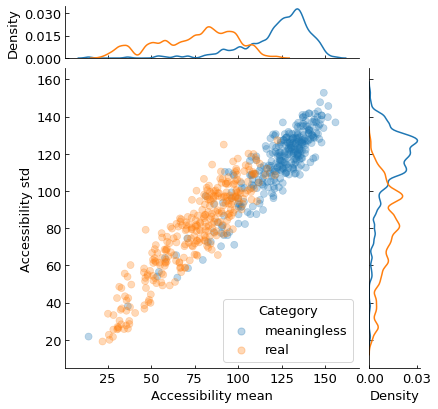

time: 2.16 s


In [75]:
### media acessibilidade vs. media simetria

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.rcParams.update({'font.size': 13})


df = pd.DataFrame()
df['means'] = means
df['stds'] = stds
df['targets'] = targets

### gi's code to plot same chart as above ###

## first, rmse calc ##
# ref: https://stackoverflow.com/questions/60512271/how-can-i-extract-the-bins-from-seaborns-kde-distplot-object
from scipy import stats

def iqr(a):
    """Calculate the IQR for an array of numbers."""
    # ref: https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/distributions.py#L24
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    
    return q3 - q1

def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    # ref: https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/utils.py#L359
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))
    
    
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    y_actual = y_actual[0]
    y_predicted = y_predicted[0]
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 4)
    
def rmse2(a, b, min_, max_):
    bins_qtt = min([_freedman_diaconis_bins(a), _freedman_diaconis_bins(b), 50])
    
    bins = np.linspace(min_, max_ + 0.01, bins_qtt)

    return rmse(np.histogram(a, bins=bins, density=True), np.histogram(b, bins=bins, density=True))


import seaborn as sns

grid = sns.JointGrid(x=df.sort_values('targets')['means'], y=df.sort_values('targets')['stds'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, 
                    alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Accessibility std')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[0], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[0], visible=False)

leg = g.ax_joint.legend(loc="lower right", scatterpoints=1, title="Category")
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='meaningless', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(x=df.loc[df['targets']=='real', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=df.loc[df['targets']=='meaningless', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=df.loc[df['targets']=='real', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)

g.ax_marg_x.set_yticks([0.000, 0.015, 0.030])
g.ax_marg_y.set_xticks([0.00, 0.03])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)




g.savefig('access_mean_std_meaningless.pdf', bbox_inches='tight')
# g.show()

In [63]:
import numpy as np

def get_accessibility_and_symmetry_random(id, level, type='Merged'):
    path = './pca 300 networks new right/network_' + id + '_RP.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h='+str(level)]), np.mean(df[type+' Accessibility h='+str(level)])


def get_accessibility_mean_and_std_random(id, level):
    path = './pca 300 networks new right/network_' + id + '_RP.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h='+str(level)]), np.std(df['Accessed Nodes h='+str(level)])


time: 0 ns


FileNotFoundError: [Errno 2] No such file or directory: './images/scores/random/only_acc_random_h2.pdf'

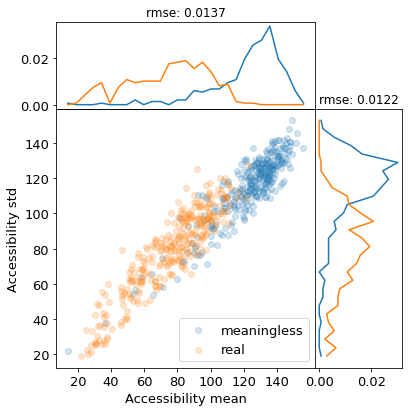

time: 8.26 s


In [74]:
### media acessibilidade vs. std acessibilidade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})

means = []
stds = []
targets = []
level = 2

for G in networks:
    id = G['gutenberg_id']
    mean, std = get_accessibility_mean_and_std(id, level)
    means.append(mean)
    stds.append(std)
    targets.append("real")
    
    mean, std = get_accessibility_mean_and_std_random(id, level)
    means.append(mean)
    stds.append(std)
    targets.append("meaningless")


df = pd.DataFrame()
df['means'] = means
df['stds'] = stds
df['targets'] = targets

fig = plt.figure(figsize=(6, 6))
fig.add_axes([0.1, 0.1, 0.6, 0.6])

for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['means'], df_filt['stds'], alpha=0.2, label=label)
    
# plt.legend()
plt.legend(loc="lower right")
# plt.suptitle("Discriminating real from meaningless using accessibility h=" + str(level))

plt.xlabel("Accessibility mean")
plt.ylabel("Accessibility std")
plt.xticks([20, 40, 60, 80, 100, 120, 140])

# first barplot
fig.add_axes([0.1, 0.7, 0.6, 0.2])
bins=np.linspace(min(means), max(means) + 1, 30)

hor_hist_f = np.histogram(df.loc[df['targets'] == 'meaningless']['means'], bins=bins, density=True)
plt.plot(hor_hist_f[1][:-1], hor_hist_f[0])

hor_hist_o = np.histogram(df.loc[df['targets'] == 'real']['means'], bins=bins, density=True)
plt.plot(hor_hist_o[1][:-1], hor_hist_o[0])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)), fontsize=12)
plt.axis('on')
plt.xticks([])

# # second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
bins=np.linspace(min(stds), max(stds) + 1, 30)

vert_hist_f = np.histogram(df.loc[df['targets'] == 'meaningless']['stds'], bins=bins, density=True)
plt.plot(vert_hist_f[0], vert_hist_f[1][:-1])

vert_hist_o = np.histogram(df.loc[df['targets'] == 'real']['stds'], bins=bins, density=True)
plt.plot(vert_hist_o[0], vert_hist_o[1][:-1])

plt.title("rmse: " + str(rmse(vert_hist_f, vert_hist_o)), fontsize=12)
plt.axis('on')
plt.yticks([])

# plt.tight_layout()
plt.savefig('./images/scores/random/only_acc_random_h'+str(level)+'.pdf')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './images/scores/random/acc_sim_random_2_Backbone.pdf'

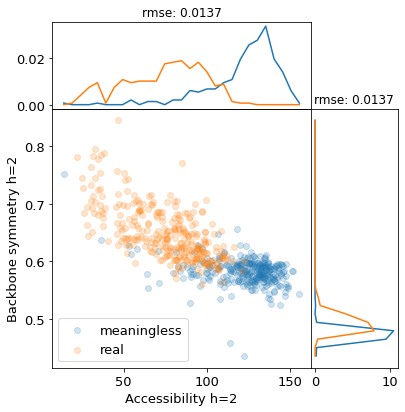

time: 7.89 s


In [70]:
### media acessibilidade vs. media simetria

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})

accessibilities = []
symmetries = []
targets = []
level = 2
type = 'Backbone'

for G in networks:
    id = G['gutenberg_id']
    acc, sim = get_accessibility_and_symmetry(id, level, type)
    accessibilities.append(acc)
    symmetries.append(sim)
    targets.append("real")
    
    acc, sim = get_accessibility_and_symmetry_random(id, level, type)
    accessibilities.append(acc)
    symmetries.append(sim)
    targets.append("meaningless")
    

df = pd.DataFrame()
df['accessibilities'] = accessibilities
df['symmetries'] = symmetries
df['targets'] = targets

fig = plt.figure(figsize=(6, 6))
fig.add_axes([0.1, 0.1, 0.6, 0.6])

for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['accessibilities'], df_filt['symmetries'], alpha=0.2, label=label)
    
plt.legend(loc="lower left")
# plt.suptitle("Discriminating real from meaningless using accessibility and " + type + " symmetry h=" + str(level))
plt.xlabel("Accessibility h="+str(level))
plt.ylabel(type + " symmetry h="+str(level))

# first barplot
fig.add_axes([0.1, 0.7, 0.6, 0.2])
bins=np.linspace(min(accessibilities), max(accessibilities) + 1, 30)

hor_hist_f = np.histogram(df.loc[df['targets'] == 'meaningless']['accessibilities'], bins=bins, density=True)
plt.plot(hor_hist_f[1][:-1], hor_hist_f[0])

hor_hist_o = np.histogram(df.loc[df['targets'] == 'real']['accessibilities'], bins=bins, density=True)
plt.plot(hor_hist_o[1][:-1], hor_hist_o[0])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)), fontsize=12)
plt.axis('on')
plt.xticks([])

# # second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
bins=np.linspace(min(symmetries), max(symmetries) + 1, 30)

vert_hist_f = np.histogram(df.loc[df['targets'] == 'meaningless']['symmetries'], bins=bins, density=True)
plt.plot(vert_hist_f[0], vert_hist_f[1][:-1])

vert_hist_o = np.histogram(df.loc[df['targets'] == 'real']['symmetries'], bins=bins, density=True)
plt.plot(vert_hist_o[0], vert_hist_o[1][:-1])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)), fontsize=12)
plt.axis('on')
plt.yticks([])

# plt.tight_layout()
plt.savefig('./images/scores/random/acc_sim_random_'+str(level)+'_'+type+'.pdf')
plt.show()

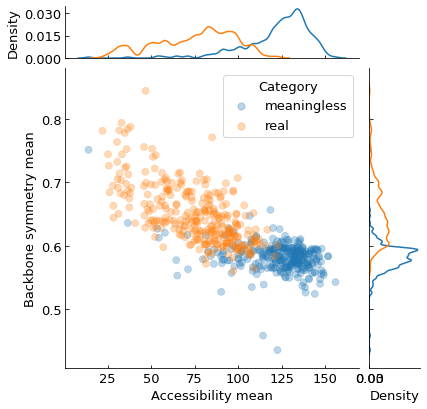

time: 2.08 s


In [73]:
### media acessibilidade vs. media simetria

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.rcParams.update({'font.size': 13})


df = pd.DataFrame()
df['means'] = accessibilities
df['stds'] = symmetries
df['targets'] = targets

### gi's code to plot same chart as above ###

## first, rmse calc ##
# ref: https://stackoverflow.com/questions/60512271/how-can-i-extract-the-bins-from-seaborns-kde-distplot-object
from scipy import stats

def iqr(a):
    """Calculate the IQR for an array of numbers."""
    # ref: https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/distributions.py#L24
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    
    return q3 - q1

def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    # ref: https://github.com/mwaskom/seaborn/blob/5498cdb2f145b15a85adac0c8ff233656f52a943/seaborn/utils.py#L359
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))
    
    
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    y_actual = y_actual[0]
    y_predicted = y_predicted[0]
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 4)
    
def rmse2(a, b, min_, max_):
    bins_qtt = min([_freedman_diaconis_bins(a), _freedman_diaconis_bins(b), 50])
    
    bins = np.linspace(min_, max_ + 0.01, bins_qtt)

    return rmse(np.histogram(a, bins=bins, density=True), np.histogram(b, bins=bins, density=True))


import seaborn as sns

grid = sns.JointGrid(x=df.sort_values('targets')['means'], y=df.sort_values('targets')['stds'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, 
                    alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Backbone symmetry mean')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[0], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[0], visible=False)

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1, title="Category")
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='meaningless', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(x=df.loc[df['targets']=='real', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=df.loc[df['targets']=='meaningless', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)
sns.kdeplot(y=df.loc[df['targets']=='real', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1)

g.ax_marg_x.set_yticks([0.000, 0.015, 0.030])
g.ax_marg_y.set_xticks([0.00, 0.03])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)




g.savefig('access_sym_mean_meaningless.pdf', bbox_inches='tight')
# g.show()

## New plots

In [1]:
### code to retrieve all networks from 'pca 300 networks' folder and store it in an array 

import os
import pickle

def getNetworkIds():

    ids = []
    path = './pca 300 networks new right/'
    directory = os.fsencode(path)

    for file in os.listdir(directory):
        filename = path + os.fsdecode(file)
        if filename.endswith("_RP.tsv"):
            # getting gutenberg_id
            start = len(path) + len('network_')
            end = len('_RP.tsv')
            gutenberg_id = filename[start:-end]
            ids.append(gutenberg_id)
            
    return ids

In [2]:
# xuxu, o novo código pros plots:

import sys
import inspect
import scipy.stats

def CountQuads(Arr2D, point):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by counting
    the proportion of points in Arr2D in each quadrant.
    :param list Arr2D: Array of points to be counted.
    :param array point: A 2 element list, point, which is the center of
    4 square quadrants.
    :returns: a tuple of 4 floats.  The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive, n for
    negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is neither list nor numpyndarray')
    if len(point) != 2:
        return
    if isinstance(Arr2D, list):
        Arr2D = np.asarray((Arr2D))
    elif type(Arr2D).__module__+type(Arr2D).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D is neither list nor numpyndarray')
    if Arr2D.shape[1] > Arr2D.shape[0]:  # Reshape to A[row,column]
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError('Input Arr2D is not 2D')
    # The pp of Qpp refer to p for 'positive' and n for 'negative' quadrants.
    # In order. first subscript is x, second is y.
    Qpp = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qnp = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qpn = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] < point[1]), :]
    Qnn = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] < point[1]), :]
    # Normalized fractions:
    ff = 1./len(Arr2D)
    fpp = len(Qpp)*ff
    fnp = len(Qnp)*ff
    fpn = len(Qpn)*ff
    fnn = len(Qnn)*ff
    # NOTE:  all the f's are supposed to sum to 1.0. Float representation
    # cause SOMETIMES sum to 1.000000002 or something. I don't know how to
    # test for that reliably, OR what to do about it yet. Keep in mind.
    return(fpp, fnp, fpn, fnn)
def FuncQuads(func2D, point, xlim, ylim, rounddig=4):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by
    integrating the density function func2D in each quadrant.
    :param array func2D: Density function that takes 2 arguments: x and y.
    :param list point: A 2 element list, point, which is the center of 4
    square quadrants.
    :param array xlim,ylim: Domain of numerical integration necessary to
    compute the quadrant probabilities.
    :returns: a tuple of 4 floats. The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive,
    n for negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError('Input func2D is not a function with 2 arguments')
        pass
    else:
        raise TypeError('Input func2D is not a function')
    # If xlim, ylim and point are not lists or ndarray, exit.
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is not a list or numpyndarray')
    if len(point) != 2:
        raise TypeError('Input point has not exactly 2 elements')
    if isinstance(xlim, list):
        xlim = np.asarray((np.sort(np.ravel(xlim))))
    elif type(xlim).__module__+type(xlim).__name__ == 'numpyndarray':
        xlim = np.sort(np.ravel(xlim.copy()))
    else:
        raise TypeError('Input xlim is not a list or ndarray')
    if len(xlim) != 2:
        raise TypeError('Input xlim has not exactly 2 elements')
    if xlim[0] == xlim[1]:
        raise TypeError('Input xlim[0] should be different to xlim[1]')
    if isinstance(ylim, list):
        ylim = np.asarray((np.sort(np.ravel(ylim))))
    elif type(ylim).__module__+type(ylim).__name__ == 'numpyndarray':
        ylim = np.sort(np.ravel(ylim.copy()))
    else:
        raise TypeError('Input ylim is not a list or ndarray')
    if len(ylim) != 2:
        raise TypeError('Input ylim has not exactly 2 elements')
    if ylim[0] == ylim[1]:
        raise TypeError('Input ylim[0] should be different to ylim[1]')
    # Numerical integration to find the quadrant probabilities.
    totInt = scipy.integrate.dblquad(func2D, *xlim,
                                     lambda x: np.amin(ylim),
                                     lambda x: np.amax(ylim))[0]
    Qpp = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qpn = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    Qnp = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qnn = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    fpp = round(Qpp/totInt, rounddig)
    fnp = round(Qnp/totInt, rounddig)
    fpn = round(Qpn/totInt, rounddig)
    fnn = round(Qnn/totInt, rounddig)
    return(fpp, fnp, fpn, fnn)
def Qks(alam, iter=100, prec=1e-17):
    """ Computes the value of the KS probability function, as a function of
    alam, the D statistic. From *Numerical recipes in C* page 623: '[...]
    the K–S statistic useful is that its distribution in the case of the null
    hypothesis (data sets drawn from the same distribution) can be calculated,
    at least to useful approximation, thus giving the significance of any
    observed nonzero value of D.' (D being the KS statistic).
    :param float alam: D statistic.
    :param int iter: Number of iterations to be perfomed. On non-convergence,
    returns 1.0.
    :param float prec: Convergence criteria of the qks. Stops converging if
    that precision is attained.
    :returns: a float. The significance level of the observed D statistic.
    """
    # If j iterations are performed, meaning that toadd
    # is still 2 times larger than the precision.
    if isinstance(alam, int) | isinstance(alam, float):
        pass
    else:
        raise TypeError('Input alam is neither int nor float')
    toadd = [1]
    qks = 0.
    j = 1
    while (j < iter) & (abs(toadd[-1]) > prec*2):
        toadd.append(2.*(-1.)**(j-1.)*np.exp(-2.*j**2.*alam**2.))
        qks += toadd[-1]
        j += 1
    if (j == iter) | (qks > 1):  # If no convergence after j iter, return 1.0
        return(1.0)
    if qks < prec:
        return(0.)
    else:
        return(qks)
def ks2d2s(Arr2D1, Arr2D2):
    """ ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    2s for 2 samples.
    KS test for goodness-of-fit on two 2D samples. Tests the hypothesis that
    the two samples are from the same distribution.
    :param array Arr2D1: 2D array of points/samples.
    :param array Arr2D2: 2D array of points/samples.
    :returns: a tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if type(Arr2D1).__module__+type(Arr2D1).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D1 is neither list nor numpyndarray')
    if Arr2D1.shape[1] > Arr2D1.shape[0]:
        Arr2D1 = Arr2D1.copy().T
    if type(Arr2D2).__module__+type(Arr2D2).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D2 is neither list nor numpyndarray')
    if Arr2D2.shape[1] > Arr2D2.shape[0]:
        Arr2D2 = Arr2D2.copy().T
    if Arr2D1.shape[1] != 2:
        raise TypeError('Input Arr2D1 is not 2D')
    if Arr2D2.shape[1] != 2:
        raise TypeError('Input Arr2D2 is not 2D')
    d1, d2 = 0., 0.
    for point1 in Arr2D1:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point1)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point1)
        d1 = max(d1, abs(fpp1-fpp2))
        d1 = max(d1, abs(fpm1-fpm2))
        d1 = max(d1, abs(fmp1-fmp2))
        d1 = max(d1, abs(fmm1-fmm2))
    for point2 in Arr2D2:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point2)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point2)
        d2 = max(d2, abs(fpp1-fpp2))
        d2 = max(d2, abs(fpm1-fpm2))
        d2 = max(d2, abs(fmp1-fmp2))
        d2 = max(d2, abs(fmm1-fmm2))
    d = (d1+d2)/2.
    sqen = np.sqrt(len(Arr2D1)*len(Arr2D2)/(len(Arr2D1)+len(Arr2D2)))
    R1 = scipy.stats.pearsonr(Arr2D1[:, 0], Arr2D1[:, 1])[0]
    R2 = scipy.stats.pearsonr(Arr2D2[:, 0], Arr2D2[:, 1])[0]
    RR = np.sqrt(1.-(R1*R1+R2*R2)/2.)
    prob = Qks(d*sqen/(1.+RR*(0.25-0.75/sqen)))
    # Small values of prob show that the two samples are significantly
    # different. Prob is the significance level of an observed value of d.
    # NOT the same as the significance level that ou set and compare to D.
    #return(d, prob)
    return round(d, 4)

In [3]:

import numpy as np

def get_accessibility_and_symmetry(id):
    path = './pca 300 networks new right/network_' + id + '.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h=2']), np.mean(df['Backbone Accessibility h=2'])


def get_accessibility_mean_and_std(id):
    path = './pca 300 networks new right/network_' + id + '.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h=2']), np.std(df['Accessed Nodes h=2'])

def get_accessibility_and_symmetry_random(id):
    path = './pca 300 networks new right/network_' + id + '_RP.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h=2']), np.mean(df['Backbone Accessibility h=2'])


def get_accessibility_mean_and_std_random(id):
    path = './pca 300 networks new right/network_' + id + '_RP.tsv'
    df = pd.read_csv(path, sep='\t')
    return np.mean(df['Accessed Nodes h=2']), np.std(df['Accessed Nodes h=2'])


### access_sym

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 13})

accessibilities = []
symmetries = []
targets = []

for id in getNetworkIds():
    acc, sim = get_accessibility_and_symmetry(id)
    accessibilities.append(acc)
    symmetries.append(sim)
    targets.append(get_book_community(id))
    

df = pd.DataFrame()
df['accessibilities'] = accessibilities
df['symmetries'] = symmetries
df['targets'] = targets

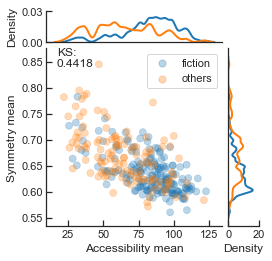

In [99]:
import seaborn as sns

sns.set(font_scale = 1.0)
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
custom_palette = ["#1f77b4", "#ff7f0e"]
sns.set_palette(palette = custom_palette)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

grid = sns.JointGrid(x=df.sort_values('targets')['accessibilities'], y=df.sort_values('targets')['symmetries'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Symmetry mean')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='fiction', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=df.loc[df['targets']=='others', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='fiction', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='others', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_x.set_yticks([0.00, 0.03])
g.ax_marg_y.set_xticks([0, 20])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_joint.text(17, 0.84, "KS:\n" + str(ks2d2s(np.array(df.loc[df['targets']=='fiction', ['accessibilities', 'symmetries']]), np.array(df.loc[df['targets']=='others', ['accessibilities', 'symmetries']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

g.savefig('access_sym.pdf', bbox_inches='tight', dpi=300)
plt.show()

### access

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 13})

accessibilities = []
symmetries = []
targets = []

for id in getNetworkIds():
    mean, std = get_accessibility_mean_and_std(id)
    accessibilities.append(mean)
    symmetries.append(std)
    targets.append(get_book_community(id))
    

df = pd.DataFrame()
df['accessibilities'] = accessibilities
df['symmetries'] = symmetries
df['targets'] = targets

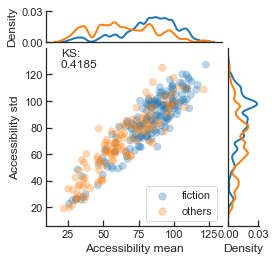

In [64]:
import seaborn as sns

sns.set(font_scale = 1.0)
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
custom_palette = ["#1f77b4", "#ff7f0e"]
sns.set_palette(palette = custom_palette)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

grid = sns.JointGrid(x=df.sort_values('targets')['accessibilities'], y=df.sort_values('targets')['symmetries'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Accessibility std')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="lower right", scatterpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='fiction', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=df.loc[df['targets']=='others', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='fiction', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='others', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_x.set_yticks([0.00, 0.03])
g.ax_marg_y.set_xticks([0, 0.03])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_joint.text(20, 125, "KS:\n" + str(ks2d2s(np.array(df.loc[df['targets']=='fiction', ['accessibilities', 'symmetries']]), np.array(df.loc[df['targets']=='others', ['accessibilities', 'symmetries']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

g.savefig('access.pdf', bbox_inches='tight', dpi=300)
plt.show()

### access_sym_random

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 13})

accessibilities = []
symmetries = []
targets = []

for id in getNetworkIds():
    mean, std = get_accessibility_and_symmetry(id)
    accessibilities.append(mean)
    symmetries.append(std)
    targets.append('real')
    
for id in getNetworkIds():
    mean, std = get_accessibility_and_symmetry_random(id)
    accessibilities.append(mean)
    symmetries.append(std)
    targets.append('meaningless')
    

df = pd.DataFrame()
df['accessibilities'] = accessibilities
df['symmetries'] = symmetries
df['targets'] = targets

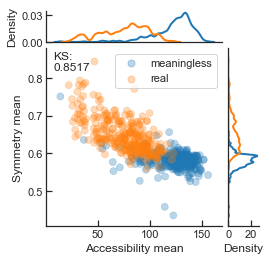

In [94]:
import seaborn as sns

sns.set(font_scale = 1.0)
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
custom_palette = ["#1f77b4", "#ff7f0e"]
sns.set_palette(palette = custom_palette)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

grid = sns.JointGrid(x=df.sort_values('targets')['accessibilities'], y=df.sort_values('targets')['symmetries'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Symmetry mean')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='meaningless', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=df.loc[df['targets']=='real', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='meaningless', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='real', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_x.set_yticks([0.00, 0.03])
g.ax_marg_y.set_xticks([0, 20])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_joint.text(7, 0.82, "KS:\n" + str(ks2d2s(np.array(df.loc[df['targets']=='real', ['accessibilities', 'symmetries']]), np.array(df.loc[df['targets']=='meaningless', ['accessibilities', 'symmetries']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

g.savefig('access_sym_random.pdf', bbox_inches='tight', dpi=300)
plt.show()

### access_random

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 13})

accessibilities = []
symmetries = []
targets = []

for id in getNetworkIds():
    mean, std = get_accessibility_mean_and_std(id)
    accessibilities.append(mean)
    symmetries.append(std)
    targets.append('real')
    
for id in getNetworkIds():
    mean, std = get_accessibility_mean_and_std_random(id)
    accessibilities.append(mean)
    symmetries.append(std)
    targets.append('meaningless')
    

df = pd.DataFrame()
df['accessibilities'] = accessibilities
df['symmetries'] = symmetries
df['targets'] = targets

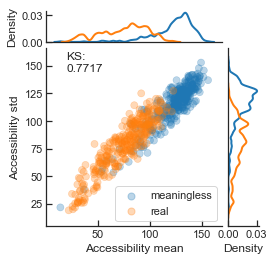

In [72]:
import seaborn as sns

sns.set(font_scale = 1.0)
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
custom_palette = ["#1f77b4", "#ff7f0e"]
sns.set_palette(palette = custom_palette)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

grid = sns.JointGrid(x=df.sort_values('targets')['accessibilities'], y=df.sort_values('targets')['symmetries'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Accessibility std')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="lower right", scatterpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='meaningless', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=df.loc[df['targets']=='real', 'accessibilities'], ax=g.ax_marg_x, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='meaningless', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='real', 'symmetries'], ax=g.ax_marg_y, legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_x.set_yticks([0.00, 0.03])
g.ax_marg_y.set_xticks([0, 0.03])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_joint.text(20, 145, "KS:\n" + str(ks2d2s(np.array(df.loc[df['targets']=='real', ['accessibilities', 'symmetries']]), np.array(df.loc[df['targets']=='meaningless', ['accessibilities', 'symmetries']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

g.savefig('access_random.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Recurrence signatures

In [10]:
def getTimeSeriesFeature(G):
    series_aux = []
    for edge in G.es:
        if edge['type'] == 'sequence':
            continue
        series_aux.append(edge.source)
        series_aux.append(edge.target)

    series_aux = list(dict.fromkeys(series_aux))
    series_aux.sort()

    series = [series_aux[0]]
    cnt = 0
    for i in range(1, len(series_aux)):
        series.append(series_aux[i] - series_aux[i-1])

    series.append(G.vcount()-1 - series_aux[-1])
    return series

time: 0 ns


## Exploring correlations

In [3]:
### loading networks

window = 4
avg_degree = 3

networks = getNetworks(window)
filtered = filterNetworkEdges(networks, avg_degree)

NameError: name 'getNetworks' is not defined

In [68]:
import pandas as pd
import numpy as np

acc_mean = []
acc_std = []
sym_mean = []
sym_std = []
rs_mean = []
rs_std = []

for G in filtered:
    mean, std = get_accessibility_mean_and_std(G['gutenberg_id'], 3)
    acc_mean.append(mean)
    acc_std.append(std)
    mean, std = get_symmetry_mean_and_std(G['gutenberg_id'], 3)
    sym_mean.append(mean)
    sym_std.append(std)
    ts = getTimeSeriesFeature(G)
    rs_mean.append(np.mean(ts))
    rs_std.append(np.std(ts))

time: 4.47 s


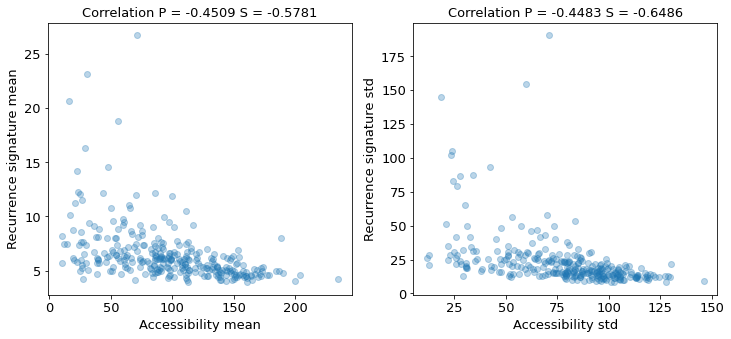

time: 594 ms


In [74]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
matplotlib.rcParams.update({'font.size': 13})


plt.figure(figsize=(12, 5))

pearson = str(round(pearsonr(acc_mean, rs_mean)[0], 4))
spearman = str(round(spearmanr(acc_mean, rs_mean)[0], 4))
plt.subplot(1, 2, 1)
plt.scatter(acc_mean, rs_mean, alpha=.3)
plt.xlabel('Accessibility mean')
plt.ylabel('Recurrence signature mean')
plt.title('Correlation P = ' + pearson + ' S = ' + spearman, fontsize=13)

pearson = str(round(pearsonr(acc_std, rs_std)[0], 4))
spearman = str(round(spearmanr(acc_std, rs_std)[0], 4))
plt.subplot(1, 2, 2)
plt.scatter(acc_std, rs_std, alpha=.3)
plt.xlabel('Accessibility std')
plt.ylabel('Recurrence signature std')
plt.title('Correlation P = ' + pearson + ' S = ' + spearman, fontsize=13)

# pearson = str(round(pearsonr(new_df['sym_mean'], new_df['rs_mean'])[0], 4))
# spearman = str(round(spearmanr(new_df['sym_mean'], new_df['rs_mean'])[0], 4))
# plt.subplot(2, 2, 3)
# plt.scatter(new_df['sym_mean'], new_df['rs_mean'])
# plt.xlabel('Symmetry mean')
# plt.ylabel('Recurrence signature mean')
# plt.title('Correlation P = ' + pearson + ' S = ' + spearman)

# pearson = str(round(pearsonr(new_df['sym_std'], new_df['rs_std'])[0], 4))
# spearman = str(round(spearmanr(new_df['sym_std'], new_df['rs_std'])[0], 4))
# plt.subplot(2, 2, 4)
# plt.scatter(new_df['sym_std'], new_df['rs_std'])
# plt.xlabel('Symmetry std')
# plt.ylabel('Recurrence signature std')
# plt.title('Correlation P = ' + pearson + ' S = ' + spearman)

# plt.savefig('correlation_acc_rs_mean.pdf')
# plt.savefig('correlation_acc_rs_std.pdf')
plt.savefig('correlation_acc_rs.pdf')
plt.show()

In [74]:
### removing outliers

from scipy.stats import zscore

df = pd.DataFrame()

df['acc_mean'] = acc_mean
df['acc_std'] = acc_std
df['sym_mean'] = sym_mean
df['sym_std'] = sym_std
df['rs_mean'] = rs_mean
df['rs_std'] = rs_std

z_scores = zscore(df)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2.8).all(axis=1)
new_df = df[filtered_entries]

len(new_df)

284

time: 15 ms


In [15]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


plt.figure(figsize=(10, 10))

pearson = str(round(pearsonr(new_df['acc_mean'], new_df['rs_mean'])[0], 4))
spearman = str(round(spearmanr(new_df['acc_mean'], new_df['rs_mean'])[0], 4))
# plt.subplot(2, 2, 1)
plt.scatter(new_df['acc_mean'], new_df['rs_mean'])
plt.xlabel('Accessibility mean')
plt.ylabel('Recurrence signature mean')
plt.title('Correlation P = ' + pearson + ' S = ' + spearman)

# pearson = str(round(pearsonr(new_df['acc_std'], new_df['rs_std'])[0], 4))
# spearman = str(round(spearmanr(new_df['acc_std'], new_df['rs_std'])[0], 4))
# plt.subplot(2, 2, 2)
# plt.scatter(new_df['acc_std'], new_df['rs_std'])
# plt.xlabel('Accessibility std')
# plt.ylabel('Recurrence signature std')
# plt.title('Correlation P = ' + pearson + ' S = ' + spearman)

# pearson = str(round(pearsonr(new_df['sym_mean'], new_df['rs_mean'])[0], 4))
# spearman = str(round(spearmanr(new_df['sym_mean'], new_df['rs_mean'])[0], 4))
# plt.subplot(2, 2, 3)
# plt.scatter(new_df['sym_mean'], new_df['rs_mean'])
# plt.xlabel('Symmetry mean')
# plt.ylabel('Recurrence signature mean')
# plt.title('Correlation P = ' + pearson + ' S = ' + spearman)

# pearson = str(round(pearsonr(new_df['sym_std'], new_df['rs_std'])[0], 4))
# spearman = str(round(spearmanr(new_df['sym_std'], new_df['rs_std'])[0], 4))
# plt.subplot(2, 2, 4)
# plt.scatter(new_df['sym_std'], new_df['rs_std'])
# plt.xlabel('Symmetry std')
# plt.ylabel('Recurrence signature std')
# plt.title('Correlation P = ' + pearson + ' S = ' + spearman)

# plt.savefig('without_outliers.jpeg')
plt.show()

NameError: name 'new_df' is not defined

<Figure size 720x720 with 0 Axes>

time: 1.66 s


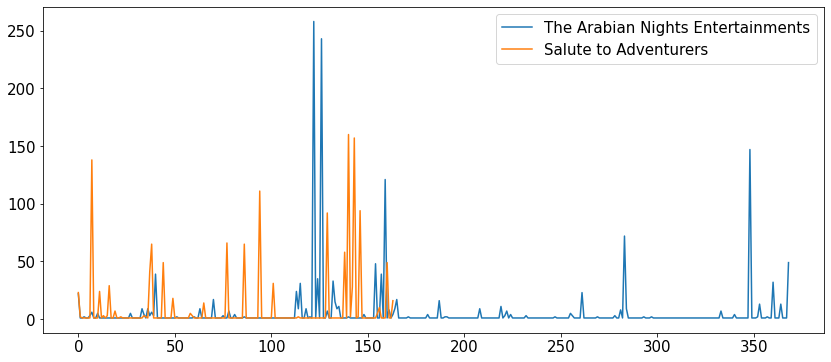

time: 437 ms


In [14]:
### Plotting the recurrence signature for a specific book
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

book_id = 128
G = pickle.load(open('./pca 300 networks new right/network_' + str(book_id) + '_w' + str(window) + '.p', 'rb'))
ts = getTimeSeriesFeature(filterNetworkEdges([G], 3)[0])

book_id = 10046
G = pickle.load(open('./pca 300 networks new right/network_' + str(book_id) + '_w' + str(window) + '.p', 'rb'))
ts2 = getTimeSeriesFeature(filterNetworkEdges([G], 3)[0])

# book_id = 258
# G = pickle.load(open('./pca 300 networks new right/network_' + str(book_id) + '_w' + str(window) + '.p', 'rb'))
# ts3 = getTimeSeriesFeature(filterNetworkEdges([G], 3)[0])

plt.figure(figsize=(14, 6))
plt.plot(ts)
plt.plot(ts2)
# plt.plot(ts3)
plt.legend([retrieve_title(128)[0], retrieve_title(10046)[0]])
plt.savefig('recurrence_signatures.pdf')

## Running experiments with the RS

### Discriminating real from meaningless

In [77]:
def getRandomNetworks(window):

    networks = []
    path = './pca 300 networks new right/'
    directory = os.fsencode(path)

    for file in os.listdir(directory):
        filename = path + os.fsdecode(file)
        if filename.endswith(str(window)+"_RP.p"):
            f = open(filename, 'rb')
            G = pickle.load(f)
            f.close()

            # getting gutenberg_id and saving on graph
            start = len(path) + len('network_')
            end = len('_w'+str(window)+'.p')
            gutenberg_id = filename[start:-end]
            
            G['gutenberg_id'] = gutenberg_id
            networks.append(G)
            
    return networks

time: 0 ns


In [78]:
window = 4
networks = getNetworks(window)
networks_random = getRandomNetworks(window)

avg_degree = 4
filtered = filterNetworkEdges(networks, avg_degree)
filtered_random = filterNetworkEdges(networks_random, avg_degree)

time: 31 s


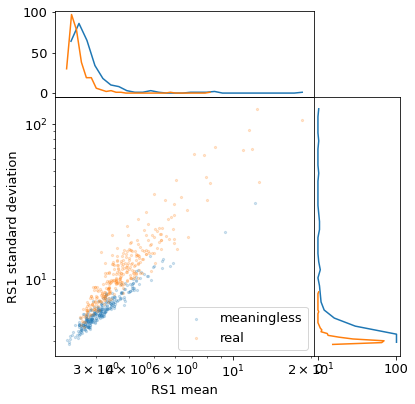

time: 2.59 s


In [79]:
import numpy as np
import pandas as pd

means = []
stds = []
targets = []
labels = []

for G in filtered:
    ts = getTimeSeriesFeature(G)
    means.append(np.mean(ts))
    stds.append(np.std(ts))
    targets.append('real')
    
for G in filtered_random:
    ts = getTimeSeriesFeature(G)
    means.append(np.mean(ts))
    stds.append(np.std(ts))
    targets.append('meaningless')
    

df = pd.DataFrame()
df['means'] = means
df['stds'] = stds
df['targets'] = targets


fig = plt.figure(figsize=(6, 6))
# plt.suptitle('Discriminating real from meaningless using the RS (logXlog)')

fig.add_axes([0.1, 0.1, 0.6, 0.6])


for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['means'], df_filt['stds'], alpha=0.2, label=label, s=5)
    
plt.legend(loc='lower right')
# plt.title("Discriminating real from shuffled texts")
plt.xlabel("RS1 mean")
plt.ylabel("RS1 standard deviation")
plt.xscale('log')
plt.yscale('log')

# first barplot

fig.add_axes([0.1, 0.7, 0.6, 0.2])
vert_hist = np.histogram(df.loc[df['targets'] == 'real']['means'], bins=30)
plt.plot(vert_hist[1][:-1], vert_hist[0])
vert_hist = np.histogram(df.loc[df['targets'] == 'meaningless']['means'], bins=30)
plt.plot(vert_hist[1][:-1], vert_hist[0])
plt.axis('on')
plt.xticks([])

# second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
vert_hist = np.histogram(df.loc[df['targets'] == 'real']['stds'], bins=30)
plt.plot(vert_hist[0], vert_hist[1][:-1])
vert_hist = np.histogram(df.loc[df['targets'] == 'meaningless']['stds'], bins=30)
plt.plot(vert_hist[0], vert_hist[1][:-1])
plt.axis('on')
plt.yticks([])

plt.show()

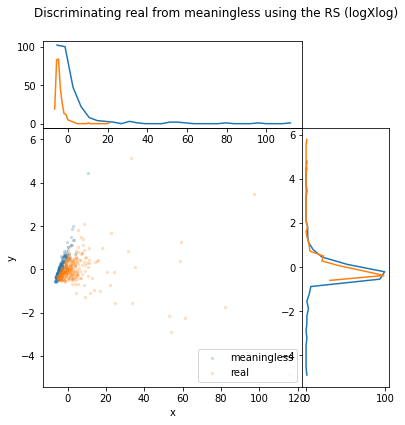

time: 1.11 s


In [85]:
### appyling pca to rotate

import numpy as np
import pandas as pd

means = []
stds = []
targets = []
labels = []

for G in filtered:
    ts = getTimeSeriesFeature(G)
    means.append(np.mean(ts))
    stds.append(np.std(ts))
    targets.append('real')
    
for G in filtered_random:
    ts = getTimeSeriesFeature(G)
    means.append(np.mean(ts))
    stds.append(np.std(ts))
    targets.append('meaningless')
    
#PCA
features = []
for i in range(len(means)):
    features.append([means[i], stds[i]])
    
pca = PCA(n_components=2)
features2d = pca.fit_transform(features)

x = list(features2d.T[0])
y = list(features2d.T[1])
    

df = pd.DataFrame()
df['means'] = x
df['stds'] = y
df['targets'] = targets


fig = plt.figure(figsize=(6, 6))
plt.suptitle('Discriminating real from meaningless using the RS (logXlog)')

fig.add_axes([0.1, 0.1, 0.6, 0.6])


for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['means'], df_filt['stds'], alpha=0.2, label=label, s=5)
    
plt.legend(loc='lower right')
# plt.title("Discriminating real from shuffled texts")
plt.xlabel("x")
plt.ylabel("y")
# plt.xscale('log')
# plt.yscale('log')

# first barplot

fig.add_axes([0.1, 0.7, 0.6, 0.2])
vert_hist = np.histogram(df.loc[df['targets'] == 'real']['means'], bins=30)
plt.plot(vert_hist[1][:-1], vert_hist[0])
vert_hist = np.histogram(df.loc[df['targets'] == 'meaningless']['means'], bins=30)
plt.plot(vert_hist[1][:-1], vert_hist[0])
plt.axis('on')

# second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
vert_hist = np.histogram(df.loc[df['targets'] == 'real']['stds'], bins=30)
plt.plot(vert_hist[0], vert_hist[1][:-1])
vert_hist = np.histogram(df.loc[df['targets'] == 'meaningless']['stds'], bins=30)
plt.plot(vert_hist[0], vert_hist[1][:-1])
plt.axis('on')

plt.show()

### Discriminating genre

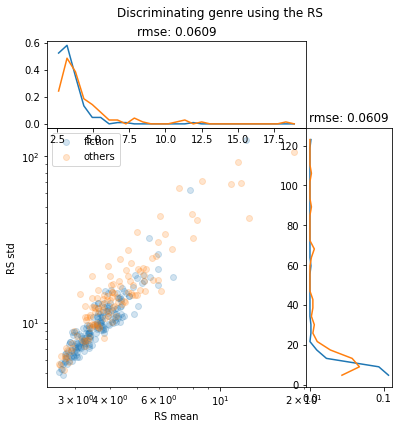

time: 1.28 s


In [70]:
### media acessibilidade vs. media simetria

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

means = []
stds = []
targets = []
labels = []

for G in filtered:
    ts = getTimeSeriesFeature(G)
    means.append(np.mean(ts))
    stds.append(np.std(ts))
    targets.append(get_book_community(G['gutenberg_id']))
    

df = pd.DataFrame()
df['means'] = means
df['stds'] = stds
df['targets'] = targets

fig = plt.figure(figsize=(6, 6))
fig.add_axes([0.1, 0.1, 0.6, 0.6])

for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['means'], df_filt['stds'], alpha=0.2, label=label)
    
plt.legend(loc="upper left")
plt.suptitle("Discriminating genre using the RS")
plt.xlabel("RS mean")
plt.ylabel("RS std")
plt.xscale('log')
plt.yscale('log')

# first barplot
fig.add_axes([0.1, 0.7, 0.6, 0.2])
bins=np.linspace(min(means), max(means) + 1, 30)

hor_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['means'], bins=bins, density=True)
plt.plot(hor_hist_f[1][:-1], hor_hist_f[0])

hor_hist_o = np.histogram(df.loc[df['targets'] == 'others']['means'], bins=bins, density=True)
plt.plot(hor_hist_o[1][:-1], hor_hist_o[0])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)))
plt.axis('on')

# # second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
bins=np.linspace(min(stds), max(stds) + 1, 30)

vert_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['stds'], bins=bins, density=True)
plt.plot(vert_hist_f[0], vert_hist_f[1][:-1])

vert_hist_o = np.histogram(df.loc[df['targets'] == 'others']['stds'], bins=bins, density=True)
plt.plot(vert_hist_o[0], vert_hist_o[1][:-1])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)))
plt.axis('on')

# plt.tight_layout()
# plt.savefig('./images/scores/acc_sim_genre_'+str(level)+'_'+type+'.pdf')
plt.show()

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def scaleData(data):
    scaler = StandardScaler()
    features = scaler.fit_transform(data)
    return features

### applying PCA

features = []
for i in range(len(means)):
    features.append([means[i], stds[i]])
    

pca = PCA(n_components=2)
features2d = pca.fit_transform(features)

x = list(features2d.T[0])
y = list(features2d.T[1])

time: 16 ms


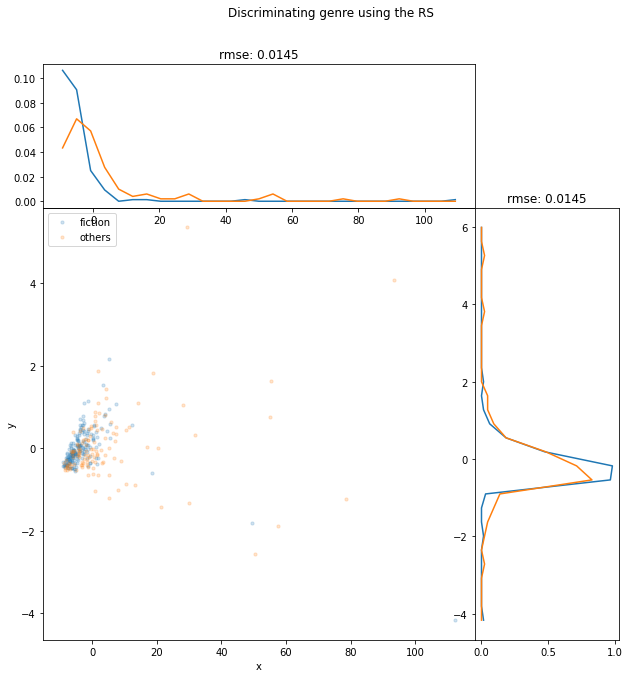

time: 406 ms


In [83]:
df = pd.DataFrame()
df['means'] = x
df['stds'] = y
df['targets'] = targets

fig = plt.figure(figsize=(10, 10))
fig.add_axes([0.1, 0.1, 0.6, 0.6])

for label, df_filt in df.groupby('targets'):
    plt.scatter(df_filt['means'], df_filt['stds'], alpha=0.2, label=label, s=10)
    
plt.legend(loc="upper left")
plt.suptitle("Discriminating genre using the RS")
plt.xlabel("x")
plt.ylabel("y")
# plt.xscale('log')
# plt.yscale('log')

# first barplot
fig.add_axes([0.1, 0.7, 0.6, 0.2])
bins=np.linspace(min(x), max(x) + 1, 30)

hor_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['means'], bins=bins, density=True)
plt.plot(hor_hist_f[1][:-1], hor_hist_f[0])

hor_hist_o = np.histogram(df.loc[df['targets'] == 'others']['means'], bins=bins, density=True)
plt.plot(hor_hist_o[1][:-1], hor_hist_o[0])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)))
plt.axis('on')

# # second barplot
fig.add_axes([0.7, 0.1, 0.2, 0.6])
bins=np.linspace(min(y), max(y) + 1, 30)

vert_hist_f = np.histogram(df.loc[df['targets'] == 'fiction']['stds'], bins=bins, density=True)
plt.plot(vert_hist_f[0], vert_hist_f[1][:-1])

vert_hist_o = np.histogram(df.loc[df['targets'] == 'others']['stds'], bins=bins, density=True)
plt.plot(vert_hist_o[0], vert_hist_o[1][:-1])

plt.title("rmse: " + str(rmse(hor_hist_f, hor_hist_o)))
plt.axis('on')

# plt.tight_layout()
# plt.savefig('./images/scores/acc_sim_genre_'+str(level)+'_'+type+'.pdf')
plt.show()